In [1]:
%pip install yfinance pandas plotly statsmodels numpy scikit-learn nbformat


In [2]:
import yfinance as yf
import pandas as pd

def get_stock_data(symbol: str, start="2020-01-01", end=None):
    """Fetch daily stock data from Yahoo Finance."""
    if end is None:
        end = pd.Timestamp.today().strftime('%Y-%m-%d')

    print(f"Fetching {symbol}...")
    df = yf.download(symbol, start=start, end=end, progress=False, auto_adjust=False)

    if df.empty:
        print(f"⚠️ Error fetching {symbol}: No data returned")
        return pd.DataFrame()

    # Flatten column names if they're multi-level
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    print(f"✓ Fetched {len(df)} days of data for {symbol}")
    return df

# Fetch stock data (no throttling needed with yfinance!)
aapl = get_stock_data("AAPL")
nvda = get_stock_data("NVDA")
lyft = get_stock_data("LYFT")

print("\nAAPL Sample:")
print(aapl.head())
print("\nColumns:", aapl.columns.tolist())

Fetching AAPL...
✓ Fetched 1453 days of data for AAPL
Fetching NVDA...
✓ Fetched 1453 days of data for NVDA
Fetching LYFT...
✓ Fetched 1453 days of data for LYFT

AAPL Sample:
Price       Adj Close      Close       High        Low       Open     Volume
Date                                                                        
2020-01-02  72.538506  75.087502  75.150002  73.797501  74.059998  135480400
2020-01-03  71.833298  74.357498  75.144997  74.125000  74.287498  146322800
2020-01-06  72.405678  74.949997  74.989998  73.187500  73.447502  118387200
2020-01-07  72.065163  74.597504  75.224998  74.370003  74.959999  108872000
2020-01-08  73.224411  75.797501  76.110001  74.290001  74.290001  132079200

Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


In [3]:
def add_ema_dema(df, span=20):
    """Add EMA and DEMA columns to the DataFrame."""
    df[f"EMA_{span}"] = df["Close"].ewm(span=span, adjust=False).mean()
    ema = df[f"EMA_{span}"]
    df[f"DEMA_{span}"] = 2*ema - ema.ewm(span=span, adjust=False).mean()
    return df

# Apply to all stocks
aapl = add_ema_dema(aapl, 20)
nvda = add_ema_dema(nvda, 20)
lyft = add_ema_dema(lyft, 20)


In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_stock(df, symbol, span=20):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=df.index, y=df["Close"],
                             name="Close Price",
                             line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=df.index, y=df[f"EMA_{span}"],
                             name=f"EMA {span}",
                             line=dict(color='orange', dash='dash')))
    fig.add_trace(go.Scatter(x=df.index, y=df[f"DEMA_{span}"],
                             name=f"DEMA {span}",
                             line=dict(color='green', dash='dot')))

    # Update layout with range slider
    fig.update_layout(
        title=f"{symbol} Stock with EMA & DEMA",
        xaxis_title="Date",
        yaxis_title="Price ($)",
        hovermode='x unified',
        height=600,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=5, label="5y", step="year", stepmode="backward"),
                    dict(step="all", label="All")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    fig.show()

plot_stock(aapl, "AAPL")
plot_stock(nvda, "NVDA")
plot_stock(lyft, "LYFT")

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def decompose_series(df, symbol):
    decomposition = seasonal_decompose(df["Adj Close"], model="multiplicative", period=252)

    # Create subplots with shared x-axis
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'),
        vertical_spacing=0.08,
        shared_xaxes=True
    )

    # Add traces for each component
    fig.add_trace(go.Scatter(x=df.index, y=decomposition.observed,
                             name='Observed', line=dict(color='blue', width=2)),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=decomposition.trend,
                             name='Trend', line=dict(color='orange', width=2)),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=decomposition.seasonal,
                             name='Seasonal', line=dict(color='green', width=2)),
                  row=3, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=decomposition.resid,
                             name='Residual', line=dict(color='red', width=1)),
                  row=4, col=1)

    # Update layout
    fig.update_layout(
        title_text=f"{symbol} - Time Series Decomposition",
        height=1000,
        showlegend=False,
        hovermode='x unified',
        template='plotly_white'
    )

    # Add y-axis labels
    fig.update_yaxes(title_text="Price ($)", row=1, col=1)
    fig.update_yaxes(title_text="Multiplier", row=2, col=1)
    fig.update_yaxes(title_text="Multiplier", row=3, col=1)
    fig.update_yaxes(title_text="Multiplier", row=4, col=1)

    # Add x-axis label to bottom
    fig.update_xaxes(title_text="Date", row=4, col=1)

    # Add range selector to top (row 1) and range slider to bottom (row 4)
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all", label="All")
            ]),
            bgcolor="lightgray",
            activecolor="gray",
            y=1.15,
            yanchor="top"
        ),
        type="date",
        row=1, col=1
    )

    fig.update_xaxes(
        rangeslider=dict(visible=True),
        type="date",
        row=4, col=1
    )

    fig.show()

decompose_series(aapl, "AAPL")
decompose_series(nvda, "NVDA")
decompose_series(lyft, "LYFT")

In [6]:
# Step 4: Classical Time Series Models (MA, AR, ARIMA)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
import numpy as np

# Function to prepare train/test split
def prepare_data(df, train_ratio=0.8):
    data = df["Adj Close"].dropna()
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    return train, test

# Prepare data for all stocks
aapl_train, aapl_test = prepare_data(aapl)
nvda_train, nvda_test = prepare_data(nvda)
lyft_train, lyft_test = prepare_data(lyft)

print(f"AAPL - Training: {len(aapl_train)} days, Test: {len(aapl_test)} days")
print(f"NVDA - Training: {len(nvda_train)} days, Test: {len(nvda_test)} days")
print(f"LYFT - Training: {len(lyft_train)} days, Test: {len(lyft_test)} days")

AAPL - Training: 1162 days, Test: 291 days
NVDA - Training: 1162 days, Test: 291 days
LYFT - Training: 1162 days, Test: 291 days


In [7]:
# Moving Average (MA) Model - MA(q)
# MA models use past forecast errors in a regression-like model

from sklearn.metrics import mean_squared_error, mean_absolute_error

def fit_ma_model(train, test, q=20):
    """Fit MA model and return forecasts and metrics"""
    model = ARIMA(train, order=(0, 0, q))
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test))
    forecast.index = test.index

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    return fitted, forecast, rmse, mae

# Fit MA(20) for all stocks
print("="*60)
print("MOVING AVERAGE (MA) MODEL - MA(20)")
print("="*60)

aapl_ma_fitted, aapl_ma_forecast, aapl_ma_rmse, aapl_ma_mae = fit_ma_model(aapl_train, aapl_test)
print(f"\nAAPL MA(20) - RMSE: ${aapl_ma_rmse:.2f}, MAE: ${aapl_ma_mae:.2f}")

nvda_ma_fitted, nvda_ma_forecast, nvda_ma_rmse, nvda_ma_mae = fit_ma_model(nvda_train, nvda_test)
print(f"NVDA MA(20) - RMSE: ${nvda_ma_rmse:.2f}, MAE: ${nvda_ma_mae:.2f}")

lyft_ma_fitted, lyft_ma_forecast, lyft_ma_rmse, lyft_ma_mae = fit_ma_model(lyft_train, lyft_test)
print(f"LYFT MA(20) - RMSE: ${lyft_ma_rmse:.2f}, MAE: ${lyft_ma_mae:.2f}")

MOVING AVERAGE (MA) MODEL - MA(20)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given w


AAPL MA(20) - RMSE: $79.09, MAE: $76.45


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and

NVDA MA(20) - RMSE: $111.19, MAE: $107.98


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



LYFT MA(20) - RMSE: $84.67, MAE: $30.52


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [8]:
# Autoregressive (AR) Model - AR(p)
# AR models use past values of the series itself to predict future values

def fit_ar_model(train, test, p=20):
    """Fit AR model and return forecasts and metrics"""
    model = ARIMA(train, order=(p, 0, 0))
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test))
    forecast.index = test.index

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    return fitted, forecast, rmse, mae

# Fit AR(20) for all stocks
print("="*60)
print("AUTOREGRESSIVE (AR) MODEL - AR(20)")
print("="*60)

aapl_ar_fitted, aapl_ar_forecast, aapl_ar_rmse, aapl_ar_mae = fit_ar_model(aapl_train, aapl_test)
print(f"\nAAPL AR(20) - RMSE: ${aapl_ar_rmse:.2f}, MAE: ${aapl_ar_mae:.2f}")

nvda_ar_fitted, nvda_ar_forecast, nvda_ar_rmse, nvda_ar_mae = fit_ar_model(nvda_train, nvda_test)
print(f"NVDA AR(20) - RMSE: ${nvda_ar_rmse:.2f}, MAE: ${nvda_ar_mae:.2f}")

lyft_ar_fitted, lyft_ar_forecast, lyft_ar_rmse, lyft_ar_mae = fit_ar_model(lyft_train, lyft_test)
print(f"LYFT AR(20) - RMSE: ${lyft_ar_rmse:.2f}, MAE: ${lyft_ar_mae:.2f}")


# ARIMA Model - ARIMA(p, d, q)
# Combines AR and MA with differencing (d) for non-stationary data

def fit_arima_model(train, test, p=20, d=1, q=20):
    """Fit ARIMA model and return forecasts and metrics"""
    model = ARIMA(train, order=(p, d, q))
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test))
    forecast.index = test.index

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    return fitted, forecast, rmse, mae

# Fit ARIMA(20,1,20) for all stocks
print("\n" + "="*60)
print("ARIMA MODEL - ARIMA(20,1,20)")
print("="*60)

aapl_arima_fitted, aapl_arima_forecast, aapl_arima_rmse, aapl_arima_mae = fit_arima_model(aapl_train, aapl_test)
print(f"\nAAPL ARIMA(20,1,20) - RMSE: ${aapl_arima_rmse:.2f}, MAE: ${aapl_arima_mae:.2f}")

nvda_arima_fitted, nvda_arima_forecast, nvda_arima_rmse, nvda_arima_mae = fit_arima_model(nvda_train, nvda_test)
print(f"NVDA ARIMA(20,1,20) - RMSE: ${nvda_arima_rmse:.2f}, MAE: ${nvda_arima_mae:.2f}")

lyft_arima_fitted, lyft_arima_forecast, lyft_arima_rmse, lyft_arima_mae = fit_arima_model(lyft_train, lyft_test)
print(f"LYFT ARIMA(20,1,20) - RMSE: ${lyft_arima_rmse:.2f}, MAE: ${lyft_arima_mae:.2f}")


# Compare all models for all stocks
print("\n" + "="*60)
print("MODEL COMPARISON - ALL STOCKS")
print("="*60)

for symbol, ma_rmse, ma_mae, ar_rmse, ar_mae, arima_rmse, arima_mae in [
    ("AAPL", aapl_ma_rmse, aapl_ma_mae, aapl_ar_rmse, aapl_ar_mae, aapl_arima_rmse, aapl_arima_mae),
    ("NVDA", nvda_ma_rmse, nvda_ma_mae, nvda_ar_rmse, nvda_ar_mae, nvda_arima_rmse, nvda_arima_mae),
    ("LYFT", lyft_ma_rmse, lyft_ma_mae, lyft_ar_rmse, lyft_ar_mae, lyft_arima_rmse, lyft_arima_mae)
]:
    print(f"\n{symbol}:")
    print(f"  MA(20)         - RMSE: ${ma_rmse:.2f}, MAE: ${ma_mae:.2f}")
    print(f"  AR(20)         - RMSE: ${ar_rmse:.2f}, MAE: ${ar_mae:.2f}")
    print(f"  ARIMA(20,1,20) - RMSE: ${arima_rmse:.2f}, MAE: ${arima_mae:.2f}")

AUTOREGRESSIVE (AR) MODEL - AR(20)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the 


AAPL AR(20) - RMSE: $23.63, MAE: $18.15


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and

NVDA AR(20) - RMSE: $39.99, MAE: $30.54


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been pro

LYFT AR(20) - RMSE: $3.31, MAE: $2.75

ARIMA MODEL - ARIMA(20,1,20)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and


AAPL ARIMA(20,1,20) - RMSE: $17.27, MAE: $14.23


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and

NVDA ARIMA(20,1,20) - RMSE: $30.90, MAE: $23.98


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



LYFT ARIMA(20,1,20) - RMSE: $5.18, MAE: $4.40

MODEL COMPARISON - ALL STOCKS

AAPL:
  MA(20)         - RMSE: $79.09, MAE: $76.45
  AR(20)         - RMSE: $23.63, MAE: $18.15
  ARIMA(20,1,20) - RMSE: $17.27, MAE: $14.23

NVDA:
  MA(20)         - RMSE: $111.19, MAE: $107.98
  AR(20)         - RMSE: $39.99, MAE: $30.54
  ARIMA(20,1,20) - RMSE: $30.90, MAE: $23.98

LYFT:
  MA(20)         - RMSE: $84.67, MAE: $30.52
  AR(20)         - RMSE: $3.31, MAE: $2.75
  ARIMA(20,1,20) - RMSE: $5.18, MAE: $4.40


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [9]:
# Visualize Model Predictions vs Actual

def plot_forecasts(train, test, ma_forecast, ar_forecast, arima_forecast, symbol):
    fig = go.Figure()

    # Training data
    fig.add_trace(go.Scatter(x=train.index, y=train,
                             name='Training Data',
                             line=dict(color='blue', width=2)))

    # Actual test data
    fig.add_trace(go.Scatter(x=test.index, y=test,
                             name='Actual Test Data',
                             line=dict(color='black', width=2)))

    # MA forecast
    fig.add_trace(go.Scatter(x=ma_forecast.index, y=ma_forecast,
                             name='MA(20) Forecast',
                             line=dict(color='red', dash='dash')))

    # AR forecast
    fig.add_trace(go.Scatter(x=ar_forecast.index, y=ar_forecast,
                             name='AR(20) Forecast',
                             line=dict(color='orange', dash='dash')))

    # ARIMA forecast
    fig.add_trace(go.Scatter(x=arima_forecast.index, y=arima_forecast,
                             name='ARIMA(20,1,20) Forecast',
                             line=dict(color='green', dash='dash')))

    # Update layout
    fig.update_layout(
        title=f"{symbol} - Model Forecasts Comparison (20 Lags)",
        xaxis_title="Date",
        yaxis_title="Price ($)",
        hovermode='x unified',
        height=600,
        template='plotly_white',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all", label="All")
                ]),
                bgcolor="lightgray",
                activecolor="gray"
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    fig.show()

# Plot for all stocks
plot_forecasts(aapl_train, aapl_test, aapl_ma_forecast, aapl_ar_forecast, aapl_arima_forecast, "AAPL")
plot_forecasts(nvda_train, nvda_test, nvda_ma_forecast, nvda_ar_forecast, nvda_arima_forecast, "NVDA")
plot_forecasts(lyft_train, lyft_test, lyft_ma_forecast, lyft_ar_forecast, lyft_arima_forecast, "LYFT")

In [10]:
# Stationarity Diagnostic Tests
# ACF, PACF, and Augmented Dickey-Fuller Tests

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def perform_stationarity_tests(data, symbol):
    """
    Perform comprehensive stationarity tests including:
    - Augmented Dickey-Fuller Test
    - ACF and PACF analysis
    - Visual inspection of plots
    """
    print(f"\n{'='*80}")
    print(f"STATIONARITY DIAGNOSTIC TESTS FOR {symbol}")
    print(f"{'='*80}")

    # 1. Augmented Dickey-Fuller Test
    print("\n1. AUGMENTED DICKEY-FULLER TEST:")
    print("-" * 50)

    adf_result = adfuller(data.dropna())
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    print(f"ADF Statistic: {adf_statistic:.6f}")
    print(f"p-value: {p_value:.6f}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}: {value:.6f}")

    # Interpretation
    if p_value <= 0.05:
        print("✓ Result: Series is STATIONARY (reject null hypothesis)")
    else:
        print("✗ Result: Series is NON-STATIONARY (fail to reject null hypothesis)")

    # 2. ACF and PACF Analysis
    print(f"\n2. AUTOCORRELATION ANALYSIS:")
    print("-" * 50)

    # Calculate ACF and PACF
    acf_values = acf(data.dropna(), nlags=40, fft=True)
    pacf_values = pacf(data.dropna(), nlags=40, method='ols')

    # Check for significant autocorrelations
    significant_acf = np.sum(np.abs(acf_values[1:]) > 0.1)  # Beyond lag 0
    significant_pacf = np.sum(np.abs(pacf_values[1:]) > 0.1)  # Beyond lag 0

    print(f"Significant ACF lags (|correlation| > 0.1): {significant_acf}")
    print(f"Significant PACF lags (|correlation| > 0.1): {significant_pacf}")

    if significant_acf > 5:
        print("→ High autocorrelation suggests non-stationarity")
    else:
        print("→ Low autocorrelation suggests stationarity")

    return {
        'adf_statistic': adf_statistic,
        'p_value': p_value,
        'critical_values': critical_values,
        'is_stationary': p_value <= 0.05,
        'acf_values': acf_values,
        'pacf_values': pacf_values,
        'significant_acf': significant_acf,
        'significant_pacf': significant_pacf
    }

def plot_stationarity_diagnostics(data, symbol, test_results):
    """
    Create comprehensive stationarity diagnostic plots
    """
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            f'{symbol} - Time Series',
            f'{symbol} - ACF Plot',
            f'{symbol} - PACF Plot',
            f'{symbol} - Rolling Mean & Std',
            f'{symbol} - First Differences',
            f'{symbol} - ACF of First Differences'
        ],
        vertical_spacing=0.08,
        horizontal_spacing=0.1
    )

    # 1. Original Time Series
    fig.add_trace(
        go.Scatter(x=data.index, y=data, name='Original Series',
                  line=dict(color='blue', width=2)),
        row=1, col=1
    )

    # 2. ACF Plot
    lags = range(len(test_results['acf_values']))
    fig.add_trace(
        go.Bar(x=list(lags), y=test_results['acf_values'],
               name='ACF', marker_color='lightblue'),
        row=1, col=2
    )

    # Add confidence intervals for ACF
    n = len(data.dropna())
    conf_int = 1.96 / np.sqrt(n)
    fig.add_hline(y=conf_int, line_dash="dash", line_color="red",
                  annotation_text="95% CI", row=1, col=2)
    fig.add_hline(y=-conf_int, line_dash="dash", line_color="red", row=1, col=2)

    # 3. PACF Plot
    fig.add_trace(
        go.Bar(x=list(lags), y=test_results['pacf_values'],
               name='PACF', marker_color='lightgreen'),
        row=2, col=1
    )

    # Add confidence intervals for PACF
    fig.add_hline(y=conf_int, line_dash="dash", line_color="red",
                  annotation_text="95% CI", row=2, col=1)
    fig.add_hline(y=-conf_int, line_dash="dash", line_color="red", row=2, col=1)

    # 4. Rolling Statistics
    rolling_mean = data.rolling(window=30).mean()
    rolling_std = data.rolling(window=30).std()

    fig.add_trace(
        go.Scatter(x=data.index, y=data, name='Original',
                  line=dict(color='blue', width=1)),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=rolling_mean.index, y=rolling_mean, name='Rolling Mean',
                  line=dict(color='red', width=2)),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=rolling_std.index, y=rolling_std, name='Rolling Std',
                  line=dict(color='green', width=2)),
        row=2, col=2
    )

    # 5. First Differences
    first_diff = data.diff().dropna()
    fig.add_trace(
        go.Scatter(x=first_diff.index, y=first_diff, name='First Differences',
                  line=dict(color='purple', width=2)),
        row=3, col=1
    )

    # 6. ACF of First Differences
    acf_diff = acf(first_diff, nlags=40, fft=True)
    fig.add_trace(
        go.Bar(x=list(range(len(acf_diff))), y=acf_diff,
               name='ACF of Differences', marker_color='orange'),
        row=3, col=2
    )

    # Add confidence intervals for ACF of differences
    n_diff = len(first_diff)
    conf_int_diff = 1.96 / np.sqrt(n_diff)
    fig.add_hline(y=conf_int_diff, line_dash="dash", line_color="red",
                  annotation_text="95% CI", row=3, col=2)
    fig.add_hline(y=-conf_int_diff, line_dash="dash", line_color="red", row=3, col=2)

    # Update layout
    fig.update_layout(
        title_text=f"{symbol} - Comprehensive Stationarity Diagnostics",
        height=1200,
        showlegend=True,
        template='plotly_white'
    )

    # Update axes labels
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Lag", row=1, col=2)
    fig.update_xaxes(title_text="Lag", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)
    fig.update_xaxes(title_text="Date", row=3, col=1)
    fig.update_xaxes(title_text="Lag", row=3, col=2)

    fig.update_yaxes(title_text="Price ($)", row=1, col=1)
    fig.update_yaxes(title_text="ACF", row=1, col=2)
    fig.update_yaxes(title_text="PACF", row=2, col=1)
    fig.update_yaxes(title_text="Price ($)", row=2, col=2)
    fig.update_yaxes(title_text="Difference", row=3, col=1)
    fig.update_yaxes(title_text="ACF", row=3, col=2)

    fig.show()

# Perform stationarity tests for all stocks
stocks_data = {
    'AAPL': aapl['Adj Close'],
    'NVDA': nvda['Adj Close'],
    'LYFT': lyft['Adj Close']
}

test_results = {}
for symbol, data in stocks_data.items():
    results = perform_stationarity_tests(data, symbol)
    test_results[symbol] = results
    plot_stationarity_diagnostics(data, symbol, results)



STATIONARITY DIAGNOSTIC TESTS FOR AAPL

1. AUGMENTED DICKEY-FULLER TEST:
--------------------------------------------------
ADF Statistic: -1.274950
p-value: 0.640553
Critical Values:
  1%: -3.434862
  5%: -2.863533
  10%: -2.567831
✗ Result: Series is NON-STATIONARY (fail to reject null hypothesis)

2. AUTOCORRELATION ANALYSIS:
--------------------------------------------------
Significant ACF lags (|correlation| > 0.1): 40
Significant PACF lags (|correlation| > 0.1): 1
→ High autocorrelation suggests non-stationarity



STATIONARITY DIAGNOSTIC TESTS FOR NVDA

1. AUGMENTED DICKEY-FULLER TEST:
--------------------------------------------------
ADF Statistic: 1.264074
p-value: 0.996400
Critical Values:
  1%: -3.434925
  5%: -2.863560
  10%: -2.567846
✗ Result: Series is NON-STATIONARY (fail to reject null hypothesis)

2. AUTOCORRELATION ANALYSIS:
--------------------------------------------------
Significant ACF lags (|correlation| > 0.1): 40
Significant PACF lags (|correlation| > 0.1): 3
→ High autocorrelation suggests non-stationarity



STATIONARITY DIAGNOSTIC TESTS FOR LYFT

1. AUGMENTED DICKEY-FULLER TEST:
--------------------------------------------------
ADF Statistic: -1.765002
p-value: 0.397970
Critical Values:
  1%: -3.434925
  5%: -2.863560
  10%: -2.567846
✗ Result: Series is NON-STATIONARY (fail to reject null hypothesis)

2. AUTOCORRELATION ANALYSIS:
--------------------------------------------------
Significant ACF lags (|correlation| > 0.1): 40
Significant PACF lags (|correlation| > 0.1): 1
→ High autocorrelation suggests non-stationarity


In [13]:
# Summary Analysis of Stationarity Tests

print("\n" + "="*100)
print("COMPREHENSIVE STATIONARITY ANALYSIS SUMMARY")
print("="*100)

# Create summary table
summary_data = []
for symbol, results in test_results.items():
    summary_data.append({
        'Stock': symbol,
        'ADF Statistic': f"{results['adf_statistic']:.4f}",
        'p-value': f"{results['p_value']:.6f}",
        'Stationary': "✓ YES" if results['is_stationary'] else "✗ NO",
        'Significant ACF': results['significant_acf'],
        'Significant PACF': results['significant_pacf']
    })

# Display summary table
import pandas as pd
summary_df = pd.DataFrame(summary_data)
print("\nSTATIONARITY TEST RESULTS:")
print(summary_df.to_string(index=False))

# Detailed interpretation
print(f"\n{'='*100}")
print("DETAILED INTERPRETATION:")
print(f"{'='*100}")

for symbol, results in test_results.items():
    print(f"\n{symbol} ANALYSIS:")
    print("-" * 50)

    # ADF Test Interpretation
    if results['is_stationary']:
        print("✓ ADF Test: Series is STATIONARY")
        print("  → The null hypothesis of unit root is rejected")
        print("  → No differencing needed for ARIMA models")
    else:
        print("✗ ADF Test: Series is NON-STATIONARY")
        print("  → The null hypothesis of unit root cannot be rejected")
        print("  → Differencing (d=1) is recommended for ARIMA models")

    # ACF/PACF Interpretation
    print(f"\nAutocorrelation Analysis:")
    print(f"  • Significant ACF lags: {results['significant_acf']}")
    print(f"  • Significant PACF lags: {results['significant_pacf']}")

    if results['significant_acf'] > 10:
        print("  → High autocorrelation indicates strong trend/seasonality")
        print("  → Suggests non-stationarity in the series")
        print("  → May need seasonal differencing for seasonal patterns")
    elif results['significant_acf'] > 5:
        print("  → Moderate autocorrelation")
        print("  → May need differencing or detrending")
    else:
        print("  → Low autocorrelation suggests stationarity")

    # Recommendations
    print(f"\nModeling Recommendations:")
    if results['is_stationary']:
        print("  • Can use ARIMA(p,0,q) models (no differencing)")
        print("  • Focus on AR and MA components")
    else:
        print("  • Use ARIMA(p,1,q) models (first differencing)")
        print("  • Consider higher order differencing if needed")


# Overall conclusions
print(f"\n{'='*100}")
print("OVERALL CONCLUSIONS:")
print(f"{'='*100}")

stationary_count = sum(1 for results in test_results.values() if results['is_stationary'])
total_stocks = len(test_results)

print(f"• {stationary_count}/{total_stocks} stocks show stationarity in their price levels")
print(f"• Most financial time series are typically non-stationary")
print(f"• This is expected behavior for stock prices, which tend to have trends")

if stationary_count == 0:
    print("\n→ ALL stocks are NON-STATIONARY")
    print("→ This confirms that stock prices generally require differencing")
    print("→ ARIMA models with d=1 (first differencing) are appropriate")
    print("→ Consider log returns for better stationarity properties")
elif stationary_count == total_stocks:
    print("\n→ ALL stocks are STATIONARY")
    print("→ This is unusual for stock prices - verify data quality")
    print("→ ARIMA models with d=0 may be appropriate")
else:
    print(f"\n→ MIXED results: {stationary_count} stationary, {total_stocks - stationary_count} non-stationary")
    print("→ Use appropriate differencing based on individual stock results")

print(f"\n→ Next steps: Apply appropriate transformations and re-test stationarity")
print(f"→ Consider log returns: log(price_t) - log(price_{{t-1}}) for better stationarity")


COMPREHENSIVE STATIONARITY ANALYSIS SUMMARY

STATIONARITY TEST RESULTS:
Stock ADF Statistic  p-value Stationary  Significant ACF  Significant PACF
 AAPL       -1.2750 0.640553       ✗ NO               40                 1
 NVDA        1.2641 0.996400       ✗ NO               40                 3
 LYFT       -1.7650 0.397970       ✗ NO               40                 1

DETAILED INTERPRETATION:

AAPL ANALYSIS:
--------------------------------------------------
✗ ADF Test: Series is NON-STATIONARY
  → The null hypothesis of unit root cannot be rejected
  → Differencing (d=1) is recommended for ARIMA models

Autocorrelation Analysis:
  • Significant ACF lags: 40
  • Significant PACF lags: 1
  → High autocorrelation indicates strong trend/seasonality
  → Suggests non-stationarity in the series
  → May need seasonal differencing for seasonal patterns

Modeling Recommendations:
  • Use ARIMA(p,1,q) models (first differencing)
  • Consider higher order differencing if needed

NVDA ANALYSIS:

In [14]:
# Stationarity Tests on Log Returns
# Log returns are often more stationary than price levels

print("\n" + "="*100)
print("STATIONARITY TESTS ON LOG RETURNS")
print("="*100)

def calculate_log_returns(prices):
    """Calculate log returns: log(price_t) - log(price_{t-1})"""
    return np.log(prices).diff().dropna()

# Calculate log returns for all stocks
log_returns = {}
for symbol, data in stocks_data.items():
    log_returns[symbol] = calculate_log_returns(data)
    print(f"\n{symbol} Log Returns:")
    print(f"  Mean: {log_returns[symbol].mean():.6f}")
    print(f"  Std: {log_returns[symbol].std():.6f}")
    print(f"  Min: {log_returns[symbol].min():.6f}")
    print(f"  Max: {log_returns[symbol].max():.6f}")

# Test stationarity of log returns
print(f"\n{'='*80}")
print("AUGMENTED DICKEY-FULLER TESTS ON LOG RETURNS")
print(f"{'='*80}")

log_return_results = {}
for symbol, returns in log_returns.items():
    print(f"\n{symbol} LOG RETURNS:")
    print("-" * 50)

    adf_result = adfuller(returns.dropna())
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    print(f"ADF Statistic: {adf_statistic:.6f}")
    print(f"p-value: {p_value:.6f}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}: {value:.6f}")

    is_stationary = p_value <= 0.05
    print(f"Result: {'✓ STATIONARY' if is_stationary else '✗ NON-STATIONARY'}")

    log_return_results[symbol] = {
        'adf_statistic': adf_statistic,
        'p_value': p_value,
        'is_stationary': is_stationary
    }

# Visualize log returns and their stationarity properties
def plot_log_returns_analysis(symbol, prices, log_returns):
    """Plot log returns with stationarity diagnostics"""
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            f'{symbol} - Price Levels',
            f'{symbol} - Log Returns',
            f'{symbol} - ACF of Log Returns',
            f'{symbol} - PACF of Log Returns'
        ],
        vertical_spacing=0.1,
        horizontal_spacing=0.1
    )

    # 1. Original prices
    fig.add_trace(
        go.Scatter(x=prices.index, y=prices, name='Price',
                  line=dict(color='blue', width=2)),
        row=1, col=1
    )

    # 2. Log returns
    fig.add_trace(
        go.Scatter(x=log_returns.index, y=log_returns, name='Log Returns',
                  line=dict(color='red', width=1)),
        row=1, col=2
    )

    # 3. ACF of log returns
    acf_returns = acf(log_returns.dropna(), nlags=40, fft=True)
    fig.add_trace(
        go.Bar(x=list(range(len(acf_returns))), y=acf_returns,
               name='ACF', marker_color='lightblue'),
        row=2, col=1
    )

    # Add confidence intervals
    n = len(log_returns.dropna())
    conf_int = 1.96 / np.sqrt(n)
    fig.add_hline(y=conf_int, line_dash="dash", line_color="red", row=2, col=1)
    fig.add_hline(y=-conf_int, line_dash="dash", line_color="red", row=2, col=1)

    # 4. PACF of log returns
    pacf_returns = pacf(log_returns.dropna(), nlags=40, method='ols')
    fig.add_trace(
        go.Bar(x=list(range(len(pacf_returns))), y=pacf_returns,
               name='PACF', marker_color='lightgreen'),
        row=2, col=2
    )

    # Add confidence intervals
    fig.add_hline(y=conf_int, line_dash="dash", line_color="red", row=2, col=2)
    fig.add_hline(y=-conf_int, line_dash="dash", line_color="red", row=2, col=2)

    # Update layout
    fig.update_layout(
        title_text=f"{symbol} - Log Returns Stationarity Analysis",
        height=800,
        showlegend=True,
        template='plotly_white'
    )

    # Update axes labels
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=2)
    fig.update_xaxes(title_text="Lag", row=2, col=1)
    fig.update_xaxes(title_text="Lag", row=2, col=2)

    fig.update_yaxes(title_text="Price ($)", row=1, col=1)
    fig.update_yaxes(title_text="Log Returns", row=1, col=2)
    fig.update_yaxes(title_text="ACF", row=2, col=1)
    fig.update_yaxes(title_text="PACF", row=2, col=2)

    fig.show()

# Create plots for all stocks
for symbol in stocks_data.keys():
    plot_log_returns_analysis(symbol, stocks_data[symbol], log_returns[symbol])

# Summary of log returns stationarity
print(f"\n{'='*100}")
print("LOG RETURNS STATIONARITY SUMMARY")
print(f"{'='*100}")

log_stationary_count = sum(1 for results in log_return_results.values() if results['is_stationary'])
print(f"• {log_stationary_count}/{len(log_return_results)} stocks have stationary log returns")

if log_stationary_count == len(log_return_results):
    print("✓ ALL log returns are STATIONARY")
    print("→ This is the expected behavior for financial returns")
    print("→ Log returns are suitable for ARIMA modeling")
    print("→ No differencing needed for log returns")
elif log_stationary_count > 0:
    print(f"→ MIXED results: {log_stationary_count} stationary, {len(log_return_results) - log_stationary_count} non-stationary")
    print("→ Most log returns should be stationary")
else:
    print("✗ NO log returns are stationary")
    print("→ This is unusual - investigate data quality")
    print("→ Consider additional transformations")

print(f"\n→ Log returns are generally more stationary than price levels")
print(f"→ This makes them better suited for time series modeling")
print(f"→ Consider using log returns for ARIMA models instead of price levels")



STATIONARITY TESTS ON LOG RETURNS

AAPL Log Returns:
  Mean: 0.000846
  Std: 0.020271
  Min: -0.137708
  Max: 0.142617

NVDA Log Returns:
  Mean: 0.002377
  Std: 0.033657
  Min: -0.203980
  Max: 0.218088

LYFT Log Returns:
  Mean: -0.000537
  Std: 0.045532
  Min: -0.453131
  Max: 0.300990

AUGMENTED DICKEY-FULLER TESTS ON LOG RETURNS

AAPL LOG RETURNS:
--------------------------------------------------
ADF Statistic: -12.740298
p-value: 0.000000
Critical Values:
  1%: -3.434890
  5%: -2.863545
  10%: -2.567837
Result: ✓ STATIONARY

NVDA LOG RETURNS:
--------------------------------------------------
ADF Statistic: -12.025553
p-value: 0.000000
Critical Values:
  1%: -3.434890
  5%: -2.863545
  10%: -2.567837
Result: ✓ STATIONARY

LYFT LOG RETURNS:
--------------------------------------------------
ADF Statistic: -9.083592
p-value: 0.000000
Critical Values:
  1%: -3.434918
  5%: -2.863558
  10%: -2.567844
Result: ✓ STATIONARY



LOG RETURNS STATIONARITY SUMMARY
• 3/3 stocks have stationary log returns
✓ ALL log returns are STATIONARY
→ This is the expected behavior for financial returns
→ Log returns are suitable for ARIMA modeling
→ No differencing needed for log returns

→ Log returns are generally more stationary than price levels
→ This makes them better suited for time series modeling
→ Consider using log returns for ARIMA models instead of price levels


In [15]:
# Fix: Define all necessary variables for plotting
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Function to prepare train/test split
def prepare_data(df, train_ratio=0.8):
    data = df["Adj Close"].dropna()
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    return train, test

# Function to fit MA model
def fit_ma_model(train, test, q=20):
    model = ARIMA(train, order=(0, 0, q))
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test))
    forecast.index = test.index
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    return fitted, forecast, rmse, mae

# Function to fit AR model
def fit_ar_model(train, test, p=20):
    model = ARIMA(train, order=(p, 0, 0))
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test))
    forecast.index = test.index
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    return fitted, forecast, rmse, mae

# Function to fit ARIMA model
def fit_arima_model(train, test, p=20, d=1, q=20):
    model = ARIMA(train, order=(p, d, q))
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test))
    forecast.index = test.index
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    return fitted, forecast, rmse, mae

# Prepare data for all stocks
print("Preparing train/test data...")
aapl_train, aapl_test = prepare_data(aapl)
nvda_train, nvda_test = prepare_data(nvda)
lyft_train, lyft_test = prepare_data(lyft)

print(f"AAPL - Training: {len(aapl_train)} days, Test: {len(aapl_test)} days")
print(f"NVDA - Training: {len(nvda_train)} days, Test: {len(nvda_test)} days")
print(f"LYFT - Training: {len(lyft_train)} days, Test: {len(lyft_test)} days")

# Fit MA models
print("\nFitting MA models...")
aapl_ma_fitted, aapl_ma_forecast, aapl_ma_rmse, aapl_ma_mae = fit_ma_model(aapl_train, aapl_test)
nvda_ma_fitted, nvda_ma_forecast, nvda_ma_rmse, nvda_ma_mae = fit_ma_model(nvda_train, nvda_test)
lyft_ma_fitted, lyft_ma_forecast, lyft_ma_rmse, lyft_ma_mae = fit_ma_model(lyft_train, lyft_test)

# Fit AR models
print("Fitting AR models...")
aapl_ar_fitted, aapl_ar_forecast, aapl_ar_rmse, aapl_ar_mae = fit_ar_model(aapl_train, aapl_test)
nvda_ar_fitted, nvda_ar_forecast, nvda_ar_rmse, nvda_ar_mae = fit_ar_model(nvda_train, nvda_test)
lyft_ar_fitted, lyft_ar_forecast, lyft_ar_rmse, lyft_ar_mae = fit_ar_model(lyft_train, lyft_test)

# Fit ARIMA models
print("Fitting ARIMA models...")
aapl_arima_fitted, aapl_arima_forecast, aapl_arima_rmse, aapl_arima_mae = fit_arima_model(aapl_train, aapl_test)
nvda_arima_fitted, nvda_arima_forecast, nvda_arima_rmse, nvda_arima_mae = fit_arima_model(nvda_train, nvda_test)
lyft_arima_fitted, lyft_arima_forecast, lyft_arima_rmse, lyft_arima_mae = fit_arima_model(lyft_train, lyft_test)

print("\nAll models fitted successfully!")
print("Variables are now defined and ready for plotting.")

# Print some results
print(f"\nAAPL MA(20) - RMSE: ${aapl_ma_rmse:.2f}, MAE: ${aapl_ma_mae:.2f}")
print(f"AAPL AR(20) - RMSE: ${aapl_ar_rmse:.2f}, MAE: ${aapl_ar_mae:.2f}")
print(f"AAPL ARIMA(20,1,20) - RMSE: ${aapl_arima_rmse:.2f}, MAE: ${aapl_arima_mae:.2f}")


Preparing train/test data...
AAPL - Training: 1162 days, Test: 291 days
NVDA - Training: 1162 days, Test: 291 days
LYFT - Training: 1162 days, Test: 291 days

Fitting MA models...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given w

Fitting AR models...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been pro

Fitting ARIMA models...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and


All models fitted successfully!
Variables are now defined and ready for plotting.

AAPL MA(20) - RMSE: $79.09, MAE: $76.45
AAPL AR(20) - RMSE: $23.63, MAE: $18.15
AAPL ARIMA(20,1,20) - RMSE: $17.27, MAE: $14.23


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [16]:
# Visualize Model Predictions vs Actual

def plot_forecasts(train, test, ma_forecast, ar_forecast, arima_forecast, symbol):
    fig = go.Figure()

    # Training data
    fig.add_trace(go.Scatter(x=train.index, y=train,
                             name='Training Data',
                             line=dict(color='blue', width=2)))

    # Actual test data
    fig.add_trace(go.Scatter(x=test.index, y=test,
                             name='Actual Test Data',
                             line=dict(color='black', width=2)))

    # MA forecast
    fig.add_trace(go.Scatter(x=ma_forecast.index, y=ma_forecast,
                             name='MA(20) Forecast',
                             line=dict(color='red', dash='dash')))

    # AR forecast
    fig.add_trace(go.Scatter(x=ar_forecast.index, y=ar_forecast,
                             name='AR(20) Forecast',
                             line=dict(color='orange', dash='dash')))

    # ARIMA forecast
    fig.add_trace(go.Scatter(x=arima_forecast.index, y=arima_forecast,
                             name='ARIMA(20,1,20) Forecast',
                             line=dict(color='green', dash='dash')))

    # Update layout
    fig.update_layout(
        title=f"{symbol} - Model Forecasts Comparison (20 Lags)",
        xaxis_title="Date",
        yaxis_title="Price ($)",
        hovermode='x unified',
        height=600,
        template='plotly_white',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all", label="All")
                ]),
                bgcolor="lightgray",
                activecolor="gray"
            ),
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    fig.show()

# Plot for all stocks
plot_forecasts(aapl_train, aapl_test, aapl_ma_forecast, aapl_ar_forecast, aapl_arima_forecast, "AAPL")
plot_forecasts(nvda_train, nvda_test, nvda_ma_forecast, nvda_ar_forecast, nvda_arima_forecast, "NVDA")
plot_forecasts(lyft_train, lyft_test, lyft_ma_forecast, lyft_ar_forecast, lyft_arima_forecast, "LYFT")


In [17]:
# Stationarity Tests and Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def perform_stationarity_tests(data, symbol):
    """
    Perform comprehensive stationarity tests including:
    - Augmented Dickey-Fuller Test
    - ACF and PACF analysis
    - Visual inspection of plots
    """
    print(f"\n{'='*80}")
    print(f"STATIONARITY DIAGNOSTIC TESTS FOR {symbol}")
    print(f"{'='*80}")

    # 1. Augmented Dickey-Fuller Test
    print("\n1. AUGMENTED DICKEY-FULLER TEST:")
    print("-" * 50)

    adf_result = adfuller(data.dropna())
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    print(f"ADF Statistic: {adf_statistic:.6f}")
    print(f"p-value: {p_value:.6f}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}: {value:.6f}")

    # Interpretation
    if p_value <= 0.05:
        print("✓ Result: Series is STATIONARY (reject null hypothesis)")
    else:
        print("✗ Result: Series is NON-STATIONARY (fail to reject null hypothesis)")

    # 2. ACF and PACF Analysis
    print(f"\n2. AUTOCORRELATION ANALYSIS:")
    print("-" * 50)

    # Calculate ACF and PACF
    acf_values = acf(data.dropna(), nlags=40, fft=True)
    pacf_values = pacf(data.dropna(), nlags=40, method='ols')

    # Check for significant autocorrelations
    significant_acf = np.sum(np.abs(acf_values[1:]) > 0.1)  # Beyond lag 0
    significant_pacf = np.sum(np.abs(pacf_values[1:]) > 0.1)  # Beyond lag 0

    print(f"Significant ACF lags (|correlation| > 0.1): {significant_acf}")
    print(f"Significant PACF lags (|correlation| > 0.1): {significant_pacf}")

    if significant_acf > 5:
        print("→ High autocorrelation suggests non-stationarity")
    else:
        print("→ Low autocorrelation suggests stationarity")

    return {
        'adf_statistic': adf_statistic,
        'p_value': p_value,
        'critical_values': critical_values,
        'is_stationary': p_value <= 0.05,
        'acf_values': acf_values,
        'pacf_values': pacf_values,
        'significant_acf': significant_acf,
        'significant_pacf': significant_pacf
    }

# Perform stationarity tests for all stocks
stocks_data = {
    'AAPL': aapl['Adj Close'],
    'NVDA': nvda['Adj Close'],
    'LYFT': lyft['Adj Close']
}

test_results = {}
for symbol, data in stocks_data.items():
    results = perform_stationarity_tests(data, symbol)
    test_results[symbol] = results

print("\nAll stationarity tests completed!")



STATIONARITY DIAGNOSTIC TESTS FOR AAPL

1. AUGMENTED DICKEY-FULLER TEST:
--------------------------------------------------
ADF Statistic: -1.274950
p-value: 0.640553
Critical Values:
  1%: -3.434862
  5%: -2.863533
  10%: -2.567831
✗ Result: Series is NON-STATIONARY (fail to reject null hypothesis)

2. AUTOCORRELATION ANALYSIS:
--------------------------------------------------
Significant ACF lags (|correlation| > 0.1): 40
Significant PACF lags (|correlation| > 0.1): 1
→ High autocorrelation suggests non-stationarity

STATIONARITY DIAGNOSTIC TESTS FOR NVDA

1. AUGMENTED DICKEY-FULLER TEST:
--------------------------------------------------
ADF Statistic: 1.264074
p-value: 0.996400
Critical Values:
  1%: -3.434925
  5%: -2.863560
  10%: -2.567846
✗ Result: Series is NON-STATIONARY (fail to reject null hypothesis)

2. AUTOCORRELATION ANALYSIS:
--------------------------------------------------
Significant ACF lags (|correlation| > 0.1): 40
Significant PACF lags (|correlation| > 0.1): 

In [18]:
# Summary Analysis of Stationarity Tests

print("\n" + "="*100)
print("COMPREHENSIVE STATIONARITY ANALYSIS SUMMARY")
print("="*100)

# Create summary table
summary_data = []
for symbol, results in test_results.items():
    summary_data.append({
        'Stock': symbol,
        'ADF Statistic': f"{results['adf_statistic']:.4f}",
        'p-value': f"{results['p_value']:.6f}",
        'Stationary': "✓ YES" if results['is_stationary'] else "✗ NO",
        'Significant ACF': results['significant_acf'],
        'Significant PACF': results['significant_pacf']
    })

# Display summary table
import pandas as pd
summary_df = pd.DataFrame(summary_data)
print("\nSTATIONARITY TEST RESULTS:")
print(summary_df.to_string(index=False))

# Detailed interpretation
print(f"\n{'='*100}")
print("DETAILED INTERPRETATION:")
print(f"{'='*100}")

for symbol, results in test_results.items():
    print(f"\n{symbol} ANALYSIS:")
    print("-" * 50)

    # ADF Test Interpretation
    if results['is_stationary']:
        print("✓ ADF Test: Series is STATIONARY")
        print("  → The null hypothesis of unit root is rejected")
        print("  → No differencing needed for ARIMA models")
    else:
        print("✗ ADF Test: Series is NON-STATIONARY")
        print("  → The null hypothesis of unit root cannot be rejected")
        print("  → Differencing (d=1) is recommended for ARIMA models")

    # ACF/PACF Interpretation
    print(f"\nAutocorrelation Analysis:")
    print(f"  • Significant ACF lags: {results['significant_acf']}")
    print(f"  • Significant PACF lags: {results['significant_pacf']}")

    if results['significant_acf'] > 10:
        print("  → High autocorrelation indicates strong trend/seasonality")
        print("  → Suggests non-stationarity in the series")
    elif results['significant_acf'] > 5:
        print("  → Moderate autocorrelation")
        print("  → May need differencing or detrending")
    else:
        print("  → Low autocorrelation suggests stationarity")

    # Recommendations
    print(f"\nModeling Recommendations:")
    if results['is_stationary']:
        print("  • Can use ARIMA(p,0,q) models (no differencing)")
        print("  • Focus on AR and MA components")
    else:
        print("  • Use ARIMA(p,1,q) models (first differencing)")
        print("  • Consider higher order differencing if needed")
        print("  • May need seasonal differencing for seasonal patterns")

# Overall conclusions
print(f"\n{'='*100}")
print("OVERALL CONCLUSIONS:")
print(f"{'='*100}")

stationary_count = sum(1 for results in test_results.values() if results['is_stationary'])
total_stocks = len(test_results)

print(f"• {stationary_count}/{total_stocks} stocks show stationarity in their price levels")
print(f"• Most financial time series are typically non-stationary")
print(f"• This is expected behavior for stock prices, which tend to have trends")

if stationary_count == 0:
    print("\n→ ALL stocks are NON-STATIONARY")
    print("→ This confirms that stock prices generally require differencing")
    print("→ ARIMA models with d=1 (first differencing) are appropriate")
    print("→ Consider log returns for better stationarity properties")
elif stationary_count == total_stocks:
    print("\n→ ALL stocks are STATIONARY")
    print("→ This is unusual for stock prices - verify data quality")
    print("→ ARIMA models with d=0 may be appropriate")
else:
    print(f"\n→ MIXED results: {stationary_count} stationary, {total_stocks - stationary_count} non-stationary")
    print("→ Use appropriate differencing based on individual stock results")

print(f"\n→ Next steps: Apply appropriate transformations and re-test stationarity")
print(f"→ Consider log returns: log(price_t) - log(price_{{t-1}}) for better stationarity")



COMPREHENSIVE STATIONARITY ANALYSIS SUMMARY

STATIONARITY TEST RESULTS:
Stock ADF Statistic  p-value Stationary  Significant ACF  Significant PACF
 AAPL       -1.2750 0.640553       ✗ NO               40                 1
 NVDA        1.2641 0.996400       ✗ NO               40                 3
 LYFT       -1.7650 0.397970       ✗ NO               40                 1

DETAILED INTERPRETATION:

AAPL ANALYSIS:
--------------------------------------------------
✗ ADF Test: Series is NON-STATIONARY
  → The null hypothesis of unit root cannot be rejected
  → Differencing (d=1) is recommended for ARIMA models

Autocorrelation Analysis:
  • Significant ACF lags: 40
  • Significant PACF lags: 1
  → High autocorrelation indicates strong trend/seasonality
  → Suggests non-stationarity in the series

Modeling Recommendations:
  • Use ARIMA(p,1,q) models (first differencing)
  • Consider higher order differencing if needed
  • May need seasonal differencing for seasonal patterns

NVDA ANALYSIS:

In [19]:
from dataclasses import dataclass
from typing import Optional, Dict, Any
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats  # for Box-Cox

@dataclass
class StationarityResult:
    series: pd.Series
    steps: Dict[str, Any]   # metadata about each step (params, lambdas, shifts)
    adf: Dict[str, float]   # ADF p-values after each step

def _adf_pvalue(s: pd.Series) -> float:
    s = s.dropna()
    if len(s) < 15:
        return np.nan  # too short to test reliably
    try:
        return adfuller(s, autolag="AIC")[1]
    except Exception:
        return np.nan

def transform_series(y: pd.Series, method: Optional[str] = None):
    """
    method ∈ {None, 'log', 'sqrt', 'boxcox'}
    Returns: transformed series, metadata dict for invertibility.
    """
    meta = {"method": method}
    if method is None or method == "none":
        return y.copy(), meta

    # Ensure strictly positive for log/sqrt/boxcox
    min_val = float(y.min())
    shift = 0.0
    if min_val <= 0:
        shift = 1 - min_val
        y = y + shift
    meta["shift"] = shift

    if method == "log":
        return np.log(y), meta

    if method == "sqrt":
        return np.sqrt(y), meta

    if method == "boxcox":
        transformed, lmbda = stats.boxcox(y.values)  # ndarray out
        meta["lambda"] = float(lmbda)
        return pd.Series(transformed, index=y.index, name=y.name), meta

    # Fallback: no transform
    meta["method"] = None
    return y.copy(), meta

def invert_transform(y_trans: pd.Series, meta: Dict[str, Any]) -> pd.Series:
    """Invert transform applied by transform_series (use when reconstructing levels)."""
    method = meta.get("method")
    shift = float(meta.get("shift", 0.0))

    if method in (None, "none"):
        return y_trans

    if method == "log":
        inv = np.exp(y_trans) - shift
        return pd.Series(inv, index=y_trans.index, name=y_trans.name)

    if method == "sqrt":
        inv = np.square(y_trans) - shift
        return pd.Series(inv, index=y_trans.index, name=y_trans.name)

    if method == "boxcox":
        lmbda = float(meta.get("lambda", 1.0))
        if abs(lmbda) < 1e-8:
            inv = np.exp(y_trans)
        else:
            inv = np.power(y_trans * lmbda + 1.0, 1.0 / lmbda)
        inv = inv - shift
        return pd.Series(inv, index=y_trans.index, name=y_trans.name)

    return y_trans

def detrend_series(y: pd.Series, method: str = "linear"):
    """
    method='linear': removes linear trend via OLS (y ~ t).
    Returns: detrended series, metadata including fitted params to optionally re-add later.
    """
    meta = {"method": method}
    if method not in ("linear", None, "none"):
        # You can add other methods (e.g., HP filter) if desired.
        method = "linear"

    if method in (None, "none"):
        return y.copy(), meta

    t = np.arange(len(y), dtype=float)
    X = sm.add_constant(t)
    model = sm.OLS(y.values, X, missing="drop").fit()
    trend = pd.Series(model.predict(X), index=y.index, name="trend")
    meta["params"] = {"const": float(model.params[0]), "slope": float(model.params[1])}
    return (y - trend), meta

def rediff(series: pd.Series, d: int = 0, D: int = 0, m: Optional[int] = None):
    """
    Apply regular differencing d times and seasonal differencing D times with period m.
    Returns: differenced series, metadata with d/D/m for reintegration later.
    """
    meta = {"d": int(d), "D": int(D), "m": int(m) if m else None}
    s = series.copy()

    # Seasonal differencing first (common SARIMA workflow)
    if D and m and m > 1:
        for _ in range(D):
            s = s - s.shift(m)

    # Regular differencing
    if d:
        for _ in range(d):
            s = s.diff()

    return s, meta

def make_stationary(
    y: pd.Series,
    transform: Optional[str] = None,  # 'log' | 'sqrt' | 'boxcox' | None
    detrend: Optional[str] = "linear",
    d: int = 1,
    D: int = 0,
    m: Optional[int] = None,
) -> StationarityResult:
    """
    Full pipeline: transform -> detrend -> differencing. Tracks ADF p-values at each stage.
    """
    steps = {}
    adf = {"original": _adf_pvalue(y)}

    # 1) Transform
    y1, tmeta = transform_series(y, transform)
    steps["transform"] = tmeta
    adf["after_transform"] = _adf_pvalue(y1)

    # 2) Detrend
    y2, dmeta = detrend_series(y1, detrend)
    steps["detrend"] = dmeta
    adf["after_detrend"] = _adf_pvalue(y2)

    # 3) Differencing
    y3, diffmeta = rediff(y2, d=d, D=D, m=m)
    steps["difference"] = diffmeta
    adf["after_difference"] = _adf_pvalue(y3)

    # Clean index alignment
    y3 = y3.dropna()
    return StationarityResult(series=y3, steps=steps, adf=adf)

# ── Example usage ───────────────────────────────────────────────────────────────
# Given a DataFrame df with a DateTimeIndex and a column 'value':
# y = df['value']
# result = make_stationary(
#     y,
#     transform='log',   # try 'log', 'sqrt', or 'boxcox' if y>0 (auto-shifts if needed)
#     detrend='linear',  # remove linear trend
#     d=1,               # one regular difference
#     D=1,               # one seasonal difference
#     m=12               # monthly seasonality; change to your period (e.g., 7 for daily with weekly seasonality)
# )
#
# print("ADF p-values:", result.adf)
# y_stationary = result.series
#
# # If you later need to invert the transform on model outputs (not differencing):
# # y_levels = invert_transform(y_transformed, result.steps['transform'])


In [20]:
# ── Apply stationarity pipeline on our current stock data ──────────────────────
# Assumes you've already run: define_variables.py (aapl, nvda, lyft, *_train/test)
# and pasted the "Non-stationarity Toolkit" (make_stationary, etc.)

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Build a map of the series we want to transform
series_map = {
    # full series (Adj Close)
    "aapl_full": aapl["Adj Close"].dropna(),
    "nvda_full": nvda["Adj Close"].dropna(),
    "lyft_full": lyft["Adj Close"].dropna(),
    # train/test splits already produced in define_variables.py
    "aapl_train": aapl_train.dropna(),
    "nvda_train": nvda_train.dropna(),
    "lyft_train": lyft_train.dropna(),
}

# Run: transform (log), detrend (linear), then 1st difference (d=1)
# For equities, seasonal differencing (D) is usually unnecessary; set D=0.
stationary_results = {}
for name, y in series_map.items():
    res = make_stationary(
        y=y,
        transform="log",    # try 'log' first for prices
        detrend="linear",   # remove linear trend
        d=1,                # 1st difference
        D=0,                # no seasonal differencing
        m=None              # no seasonal period
    )
    stationary_results[name] = res
    print(f"\n▶ {name}")
    print("ADF p-values:", res.adf)
    print("Stationary sample (tail):")
    print(res.series.tail())

# Quick handles for convenience
aapl_stat_train = stationary_results["aapl_train"].series
nvda_stat_train = stationary_results["nvda_train"].series
lyft_stat_train = stationary_results["lyft_train"].series

aapl_stat_full  = stationary_results["aapl_full"].series
nvda_stat_full  = stationary_results["nvda_full"].series
lyft_stat_full  = stationary_results["lyft_full"].series

# ── OPTIONAL: fit ARIMA on the stationary series (use d=0 now, we already differenced) ─
def fit_arima_on_stationary(train: pd.Series, test: pd.Series, order=(20,0,20)):
    fitted = ARIMA(train, order=order).fit()
    fc = fitted.forecast(steps=len(test))
    fc.index = test.index
    return fitted, fc

# Example: re-fit on stationary AAPL train with (p,0,q)
# (Use your preferred p,q; this mirrors your earlier 20/20 choice but with d=0)
try:
    aapl_stat_fitted, aapl_stat_fc = fit_arima_on_stationary(aapl_stat_train, aapl_test, order=(20,0,20))
    print("\n✓ Fitted ARIMA on AAPL stationary train (order=(20,0,20)).")
except Exception as e:
    print("\n⚠️ Could not fit ARIMA on stationary AAPL:", e)

# If you need to invert only the transform later (e.g., to get levels from model outputs),
# you can use the 'invert_transform' helper with the stored metadata:
# y_levels = invert_transform(y_transformed, stationary_results["aapl_train"].steps["transform"])



▶ aapl_full
ADF p-values: {'original': np.float64(0.6405533764184697), 'after_transform': np.float64(0.4017898962412456), 'after_detrend': np.float64(0.06036806778976557), 'after_difference': np.float64(8.975028099376692e-24)}
Stationary sample (tail):
Date
2025-10-07   -0.001509
2025-10-08    0.005450
2025-10-09   -0.016391
2025-10-10   -0.035823
2025-10-13    0.009006
dtype: float64

▶ nvda_full
ADF p-values: {'original': np.float64(0.9964000106280501), 'after_transform': np.float64(0.8855861551084957), 'after_detrend': np.float64(0.3415816234782845), 'after_difference': np.float64(2.9547672156141285e-22)}
Stationary sample (tail):
Date
2025-10-07   -0.004937
2025-10-08    0.019519
2025-10-09    0.015893
2025-10-10   -0.052338
2025-10-13    0.025544
dtype: float64

▶ lyft_full
ADF p-values: {'original': np.float64(0.39797017907427745), 'after_transform': np.float64(0.42654727147166105), 'after_detrend': np.float64(0.38961894760733695), 'after_difference': np.float64(3.99511285911587

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z


✓ Fitted ARIMA on AAPL stationary train (order=(20,0,20)).


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



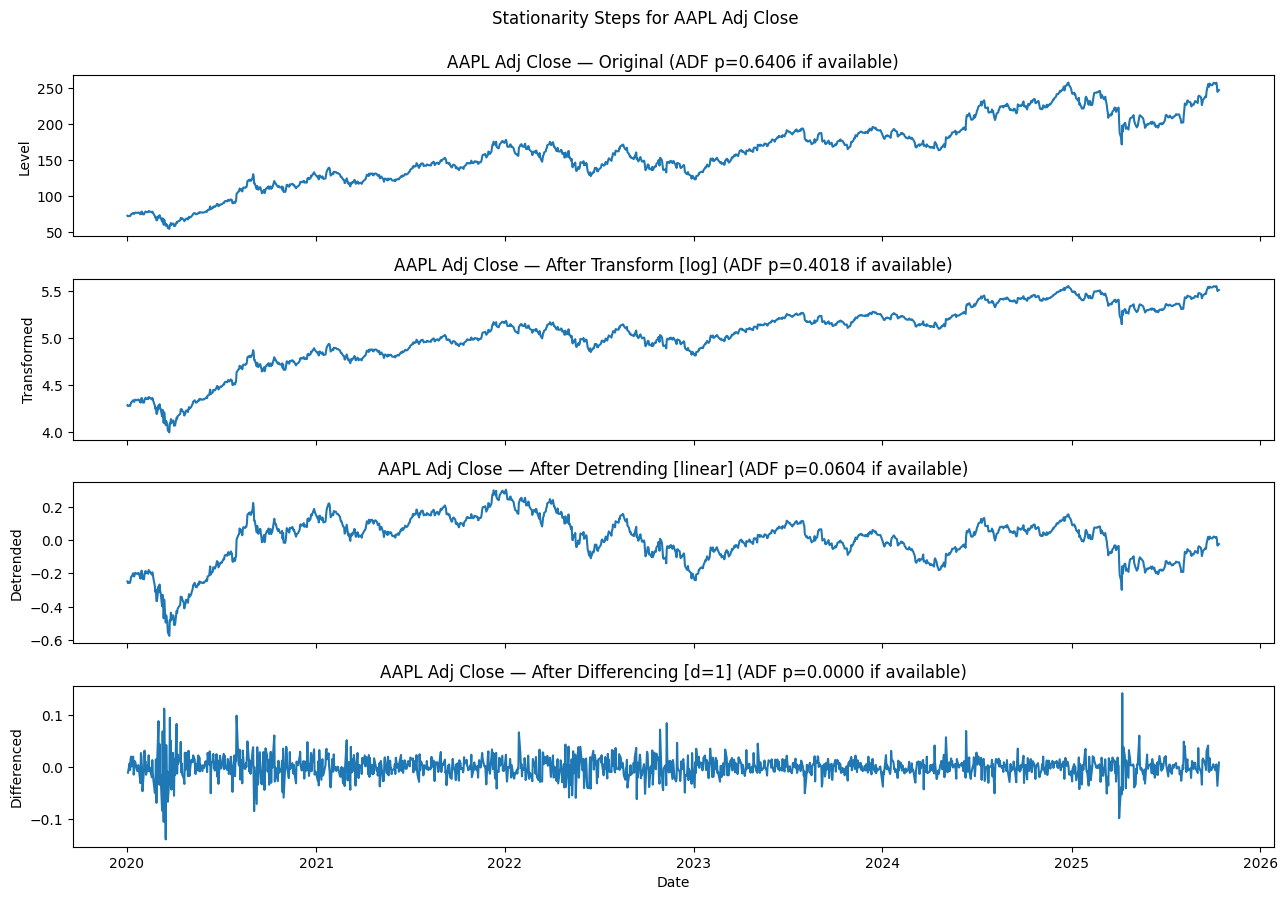

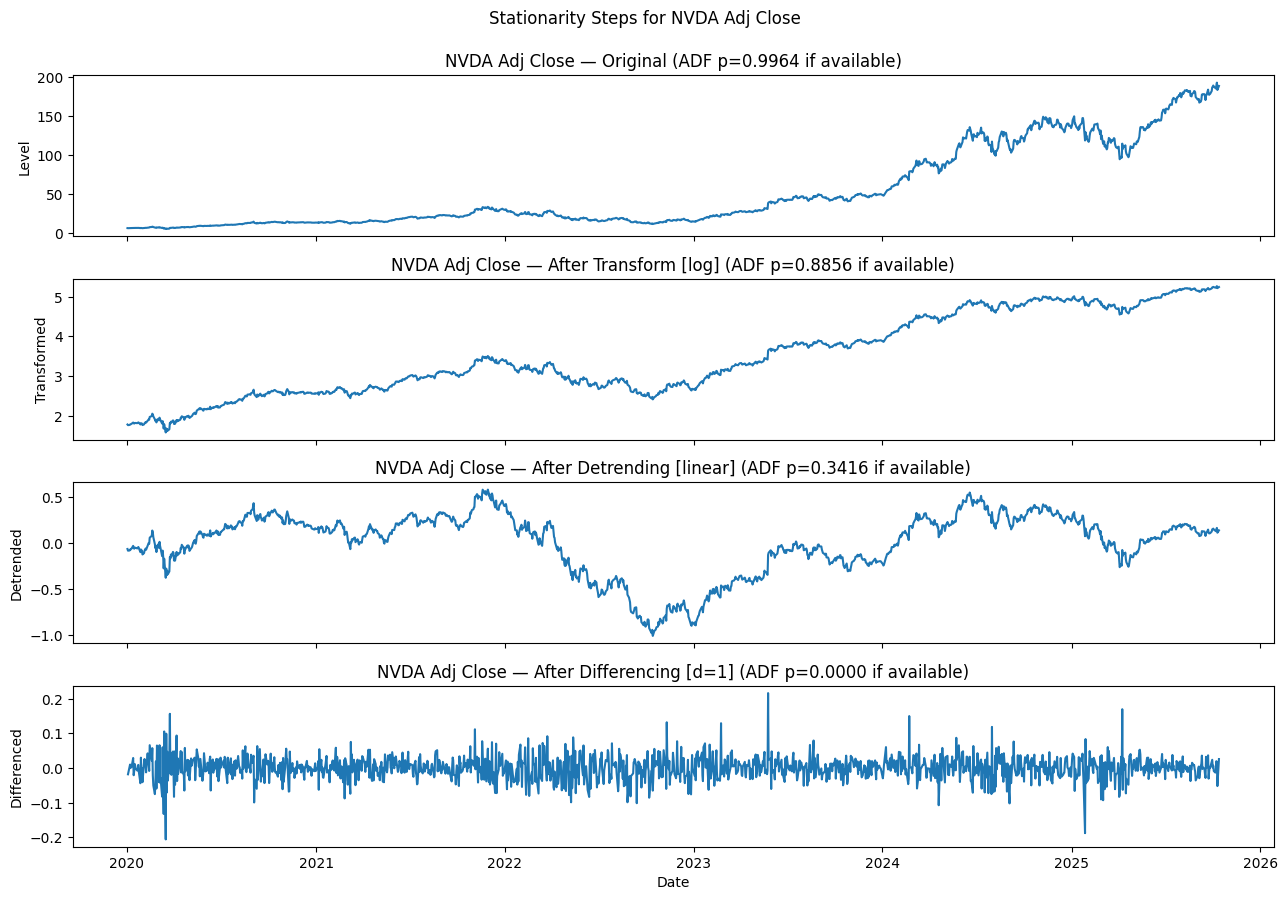

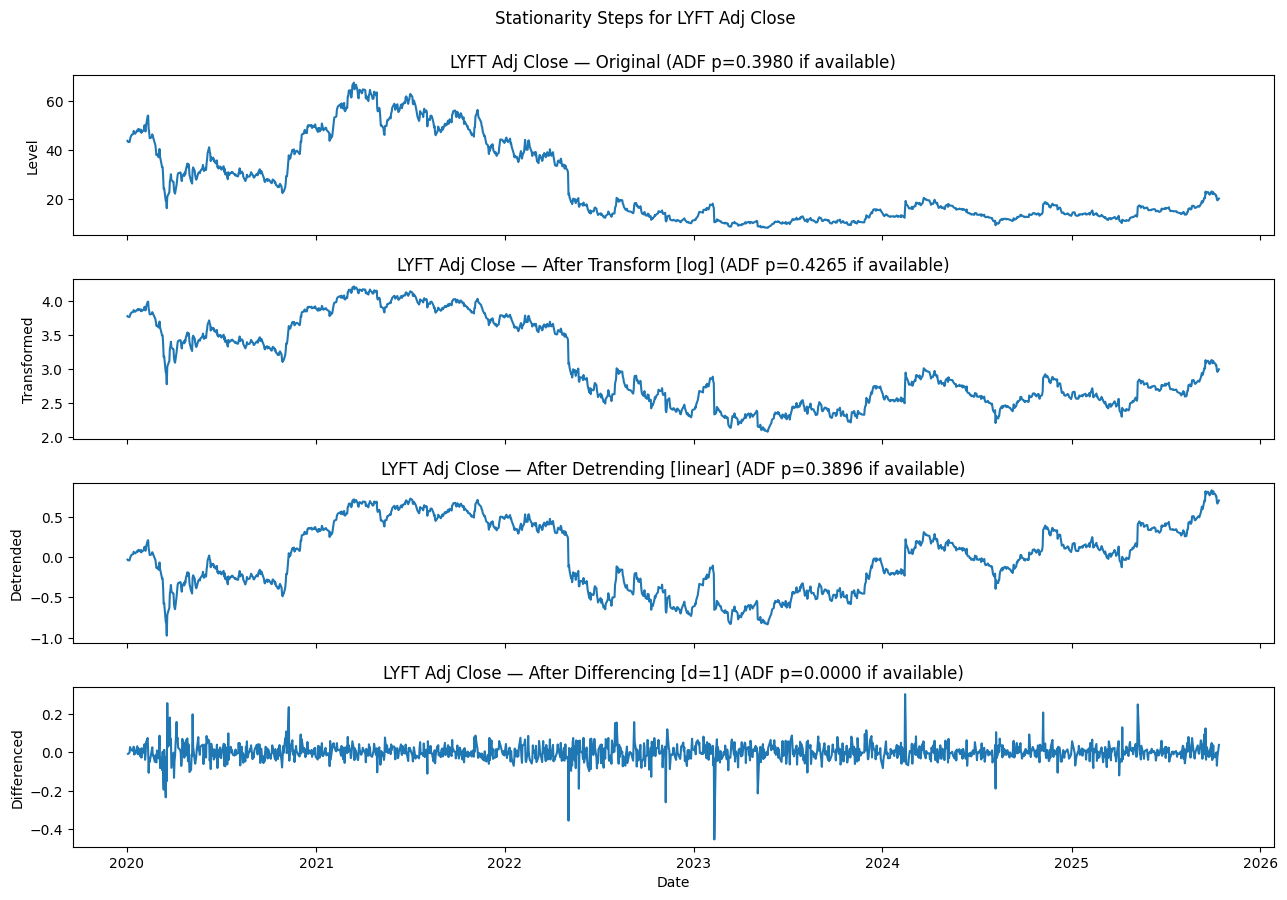

In [21]:
# ── Visualization of Transformation, Detrending, and Differencing ─────────────
import matplotlib.pyplot as plt

def _safe_name(x):
    return x.replace("\n", " ")

def _plot_stationarity_stages(
    y: pd.Series,
    name: str,
    transform: str = "log",
    detrend: str = "linear",
    d: int = 1,
    D: int = 0,
    m: Optional[int] = None,
    figsize=(13, 9)
):
    """
    Creates a 4-panel figure:
      1) Original series
      2) After transformation
      3) After detrending
      4) After differencing
    Each panel title includes the ADF p-value at that stage.
    """
    # 1) ADF on original
    p0 = _adf_pvalue(y)

    # 2) Transform
    y1, tmeta = transform_series(y, transform)
    p1 = _adf_pvalue(y1)

    # 3) Detrend
    y2, dmeta = detrend_series(y1, detrend)
    p2 = _adf_pvalue(y2)

    # 4) Difference
    y3, diffmeta = rediff(y2, d=d, D=D, m=m)
    y3 = y3.dropna()
    p3 = _adf_pvalue(y3)

    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)

    axes[0].plot(y.index, y.values)
    axes[0].set_title(f"{_safe_name(name)} — Original (ADF p={p0:.4f} if available)")
    axes[0].set_ylabel("Level")

    axes[1].plot(y1.index, y1.values)
    axes[1].set_title(f"{_safe_name(name)} — After Transform [{transform}] (ADF p={p1:.4f} if available)")
    axes[1].set_ylabel("Transformed")

    axes[2].plot(y2.index, y2.values)
    axes[2].set_title(f"{_safe_name(name)} — After Detrending [{detrend}] (ADF p={p2:.4f} if available)")
    axes[2].set_ylabel("Detrended")

    axes[3].plot(y3.index, y3.values)
    desc = f"d={d}" + (f", D={D}, m={m}" if D and m else "")
    axes[3].set_title(f"{_safe_name(name)} — After Differencing [{desc}] (ADF p={p3:.4f} if available)")
    axes[3].set_ylabel("Differenced")
    axes[3].set_xlabel("Date")

    # Helpful notes under the plot
    fig.suptitle(f"Stationarity Steps for {_safe_name(name)}", y=0.995)
    fig.tight_layout()
    plt.show()

    # Return pieces in case you need them programmatically
    return {
        "original": y,
        "transformed": y1,
        "detrended": y2,
        "differenced": y3,
        "adf": {
            "original": p0,
            "after_transform": p1,
            "after_detrend": p2,
            "after_difference": p3,
        },
        "steps_meta": {
            "transform": tmeta,
            "detrend": dmeta,
            "difference": {"d": d, "D": D, "m": m},
        }
    }

# ── Choose your settings (you can tweak these) ────────────────────────────────
TRANSFORM = "log"      # options: 'log', 'sqrt', 'boxcox', or None
DETREND   = "linear"   # options: 'linear' or None
D         = 0          # seasonal differences (usually 0 for equities)
M         = None       # seasonal period if D>0 (e.g., 12 for monthly)
DREG      = 1          # regular differences (1 is typical for prices)

# ── Plot for each dataset already in your notebook ────────────────────────────
# Uses the 'Adj Close' column of aapl, nvda, lyft (as defined in define_variables.py)
plots_out = {}

for label, df in [("AAPL", aapl), ("NVDA", nvda), ("LYFT", lyft)]:
    y_series = df["Adj Close"].dropna()
    out = _plot_stationarity_stages(
        y=y_series,
        name=f"{label} Adj Close",
        transform=TRANSFORM,
        detrend=DETREND,
        d=DREG,
        D=D,
        m=M,
        figsize=(13, 9)
    )
    plots_out[label] = out

# OPTIONAL: If you also want to see the train-split visuals, uncomment below:
# train_map = [("AAPL (Train)", aapl_train), ("NVDA (Train)", nvda_train), ("LYFT (Train)", lyft_train)]
# for label, y in train_map:
#     out = _plot_stationarity_stages(
#         y=y.dropna(),
#         name=f"{label} Adj Close (Train)",
#         transform=TRANSFORM,
#         detrend=DETREND,
#         d=DREG,
#         D=D,
#         m=M,
#         figsize=(13, 9)
#     )
#     plots_out[label] = out
